In [1]:
%pip install transformers pytorch-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 3.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 12.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.3
    Uninstalling urllib3-2.2.3:
      Successfully uninstalled urllib3-2.2.3

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# 코드 10-40 라이브러리 호출
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pytorch_transformers import (
    BertTokenizer,
    BertForSequenceClassification,
)  # 버트 사용을 위한 라이브러리
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)  # 모델 평가를 위해 사용
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 코드 10-41 데이터셋 불러오기
train_df = pd.read_csv("../chap10/data/training.txt", sep="\t")
valid_df = pd.read_csv("../chap10/data/validing.txt", sep="\t")
test_df = pd.read_csv("../chap10/data/testing.txt", sep="\t")

In [4]:
# 코드 10-42 불러온 데이터셋 중 일부만 사용
train_df = train_df.sample(frac=0.1, random_state=500)
valid_df = valid_df.sample(frac=0.1, random_state=500)
test_df = test_df.sample(frac=0.1, random_state=500)

In [5]:
# 코드 10-43 데이터셋 생성
class Datasets(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx, 1]  # ①
        label = self.df.iloc[idx, 2]
        return text, label

In [6]:
# 코드 10-44 데이터셋의 데이터를 데이터로더로 전달
train_dataset = Datasets(train_df)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)

valid_dataset = Datasets(valid_df)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=True, num_workers=0)

test_dataset = Datasets(test_df)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=0)

In [7]:
# 코드 10-45 버트 토크나이저 내려받기
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")  # ①
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")  # ②
model.to(device)

100%|██████████| 440473133/440473133 [01:08<00:00, 6421034.72B/s] 


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [8]:
# 코드 10-46 최적화 모델 저장
def save_checkpoint(save_path, model, valid_loss):  # 모델 평가를 위해 훈련 과정을 저장
    if save_path == None:
        return
    state_dict = {"model_state_dict": model.state_dict(), "valid_loss": valid_loss}
    torch.save(state_dict, save_path)
    print(f"Model saved to ==> {save_path}")


def load_checkpoint(
    load_path, model
):  # save_checkpoint 함수에서 저장된 모델을 가져옵니다.
    if load_path == None:
        return
    state_dict = torch.load(load_path, map_location=device)
    print(f"Model loaded from <== {load_path}")
    model.load_state_dict(state_dict["model_state_dict"])
    return state_dict["valid_loss"]


def save_metrics(
    save_path, train_loss_list, valid_loss_list, global_steps_list
):  # 훈련, 검증에 대한 오차와 에포크를 저장
    if save_path == None:
        return
    state_dict = {
        "train_loss_list": train_loss_list,
        "valid_loss_list": valid_loss_list,
        "global_steps_list": global_steps_list,
    }
    torch.save(state_dict, save_path)
    print(f"Model saved to ==> {save_path}")


def load_metrics(load_path):  # save_metrics에 저장해 둔 정보를 불러옵니다.
    if load_path == None:
        return
    state_dict = torch.load(load_path, map_location=device)
    print(f"Model loaded from <== {load_path}")
    return (
        state_dict["train_loss_list"],
        state_dict["valid_loss_list"],
        state_dict["global_steps_list"],
    )

In [9]:
# 코드 10-47 모델 훈련 함수 정의
def train(
    model,
    optimizer,
    criterion=nn.BCELoss(),  # 영화 리뷰는 좋고 나쁨만 있으므로 BinaryCrossEntropy(BCELoss)를 사용
    num_epochs=5,  # 에포크를 5로 사용
    eval_every=len(train_loader) // 2,
    best_valid_loss=float("Inf"),
):

    total_correct = 0.0
    total_len = 0.0
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    model.train()  # 모델 훈련
    for epoch in range(num_epochs):
        for text, label in train_loader:
            optimizer.zero_grad()
            encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
            padded_list = [
                e + [0] * (512 - len(e)) for e in encoded_list
            ]  # 인코딩 결과에 제로패딩(zero-padding)을 적용
            sample = torch.tensor(padded_list)
            sample, label = sample.to(device), label.to(device)
            labels = torch.tensor(label)
            outputs = model(sample, labels=labels)
            loss, logits = outputs

            pred = torch.argmax(F.softmax(logits), dim=1)  # ①
            correct = pred.eq(labels)
            total_correct += correct.sum().item()
            total_len += len(labels)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            global_step += 1

            if global_step % eval_every == 0:  # 모델 평가
                model.eval()
                with torch.no_grad():
                    for text, label in valid_loader:
                        encoded_list = [
                            tokenizer.encode(t, add_special_tokens=True) for t in text
                        ]
                        padded_list = [e + [0] * (512 - len(e)) for e in encoded_list]
                        sample = torch.tensor(padded_list)
                        sample, label = sample.to(device), label.to(device)
                        labels = torch.tensor(label)
                        outputs = model(sample, labels=labels)
                        loss, logits = outputs
                        valid_running_loss += loss.item()

                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                running_loss = 0.0
                valid_running_loss = 0.0
                model.train()

                print(
                    "Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}".format(
                        epoch + 1,
                        num_epochs,
                        global_step,
                        num_epochs * len(train_loader),
                        average_train_loss,
                        average_valid_loss,
                    )
                )

                if best_valid_loss > average_valid_loss:  # ②
                    best_valid_loss = average_valid_loss
                    save_checkpoint(
                        "../chap10/data/model.pt", model, best_valid_loss
                    )  # 오차가 작아지면 모델 저장
                    save_metrics(
                        "../chap10/data/metrics.pt",
                        train_loss_list,
                        valid_loss_list,
                        global_steps_list,
                    )  # 평가에 사용된 훈련 오차, 검증 오차, 에포크(스텝)를 저장

        save_metrics(
            "../chap10/data/metrics.pt",
            train_loss_list,
            valid_loss_list,
            global_steps_list,
        )  # 최종으로 사용된 훈련 오차, 검증 오차, 에포크(스텝)를 저장
        print("훈련 종료!")

In [10]:
# 코드 10-48 모델의 파라미터(옵티마이저) 미세 조정 및 모델 훈련
optimizer = optim.Adam(
    model.parameters(), lr=2e-5
)  # 아담 옵티마이저와 적절한 학습률(2e-5)로 버트 모델을 미세 조정합니다.
train(model=model, optimizer=optimizer)  # 모델을 학습시킵니다.

/tmp/ipykernel_63246/2833890866.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(label)
/tmp/ipykernel_63246/2833890866.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(F.softmax(logits), dim=1)  # ①
/tmp/ipykernel_63246/2833890866.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(label)


Epoch [1/5], Step [510/5100], Train Loss: 0.7212, Valid Loss: 0.6939
Model saved to ==> ../chap10/data/model.pt
Model saved to ==> ../chap10/data/metrics.pt
Epoch [1/5], Step [1020/5100], Train Loss: 0.7065, Valid Loss: 0.6931
Model saved to ==> ../chap10/data/model.pt
Model saved to ==> ../chap10/data/metrics.pt
Model saved to ==> ../chap10/data/metrics.pt
훈련 종료!
Epoch [2/5], Step [1530/5100], Train Loss: 0.7049, Valid Loss: 0.6960
Epoch [2/5], Step [2040/5100], Train Loss: 0.7023, Valid Loss: 0.7029
Model saved to ==> ../chap10/data/metrics.pt
훈련 종료!
Epoch [3/5], Step [2550/5100], Train Loss: 0.7060, Valid Loss: 0.6933
Epoch [3/5], Step [3060/5100], Train Loss: 0.7004, Valid Loss: 0.7341
Model saved to ==> ../chap10/data/metrics.pt
훈련 종료!
Epoch [4/5], Step [3570/5100], Train Loss: 0.7019, Valid Loss: 0.6934
Epoch [4/5], Step [4080/5100], Train Loss: 0.7009, Valid Loss: 0.7172
Model saved to ==> ../chap10/data/metrics.pt
훈련 종료!
Epoch [5/5], Step [4590/5100], Train Loss: 0.7107, Valid 

Model loaded from <== ../chap10/data/metrics.pt


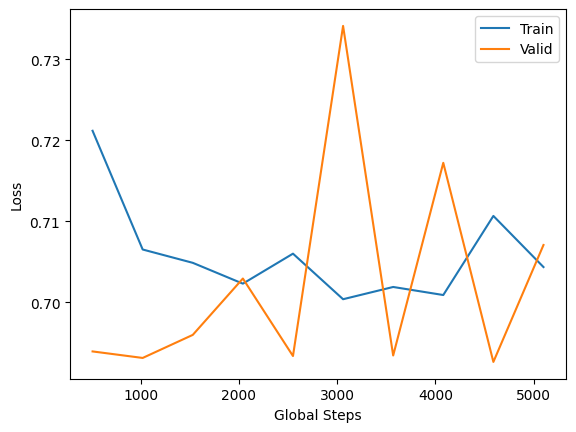

In [11]:
# 코드 10-49 오차 정보를 그래프로 확인
train_loss_list, valid_loss_list, global_steps_list = load_metrics(
    "../chap10/data/metrics.pt"
)  # 최종으로 저장된 모델을 불러옵니다.

plt.plot(global_steps_list, train_loss_list, label="Train")  # 훈련 데이터셋에 대한 오차
plt.plot(global_steps_list, valid_loss_list, label="Valid")  # 검증 데이터셋에 대한 오차
plt.xlabel("Global Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
# 코드 10-50 모델 평가 함수 정의
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()  # 테스트 데이터셋으로 모델 평가
    with torch.no_grad():
        for text, label in test_loader:
            encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
            padded_list = [e + [0] * (512 - len(e)) for e in encoded_list]
            sample = torch.tensor(padded_list)
            sample, label = sample.to(device), label.to(device)
            labels = torch.tensor(label)
            output = model(sample, labels=labels)
            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())

    print("Classification 결과:")
    print(classification_report(y_true, y_pred, labels=[1, 0], digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])  # ①
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="d")  # ②
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    ax.xaxis.set_ticklabels(["0", "1"])
    ax.yaxis.set_ticklabels(["0", "1"])

Model loaded from <== ../chap10/data/model.pt


/tmp/ipykernel_63246/386628495.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(label)


Classification 결과:
              precision    recall  f1-score   support

           1     0.5091    1.0000    0.6747       558
           0     0.0000    0.0000    0.0000       538

    accuracy                         0.5091      1096
   macro avg     0.2546    0.5000    0.3374      1096
weighted avg     0.2592    0.5091    0.3435      1096



/home/halozhan/딥러닝 파이토치 교과서/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/halozhan/딥러닝 파이토치 교과서/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/halozhan/딥러닝 파이토치 교과서/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

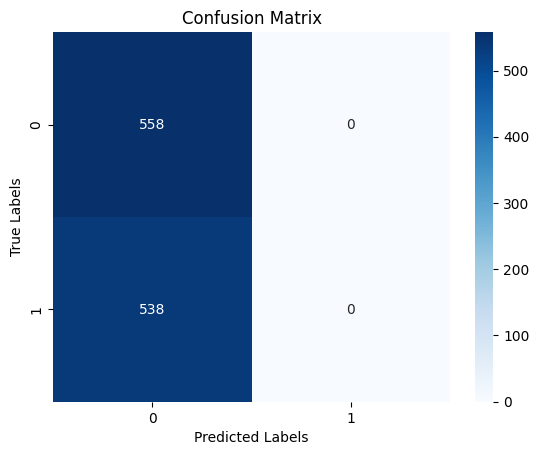

In [13]:
# 코드 10-51 모델 평가
best_model = model.to(device)
load_checkpoint("../chap10/data/model.pt", best_model)
evaluate(best_model, test_loader)